# Hand Abnormality Classification

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
pd.set_option('display.max_colwidth', 1000)
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
import random
import sklearn
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow_hub as hub
import os

In [5]:
train_df = pd.read_csv("/content/drive/Othercomputers/macbookpro/MURA-v1.1/train_image_paths.csv", names = ["path"])
val_df = pd.read_csv("/content/drive/Othercomputers/macbookpro/MURA-v1.1/valid_image_paths.csv", names = ["path"])

In [6]:
train_df.head()

,path
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image1.png
1,MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image2.png
2,MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image3.png
3,MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/image1.png
4,MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/image2.png


In [41]:
def get_label(path):
  if "positive" in path.split("/")[-2]:
    return 1
  if "negative" in path.split("/")[-2]:
    return 0

def get_bodypart(path):
  return path.split("/")[2]

def get_study(path):
  return str(path.split("/")[-3]) + "/" + str(path.split("/")[-2])

def set_df(df):
  labels = [get_label(i) for i in df.path]
  df["abnormality"] = labels
  bodyparts = [get_bodypart(i) for i in df.path]
  df["bodypart"] = bodyparts
  studies = [get_study(i) for i in df.path]
  df["study"] = studies
  # Adding drive directory prefix
  paths = np.array(df.path)
  drive_prefix = "/content/drive/Othercomputers/macbookpro/"
  paths = drive_prefix + paths
  df["path"] = paths
  return df

In [8]:
train_df = set_df(train_df)
val_df = set_df(val_df)
train_df

,path,abnormality,bodypart,study
0,/content/drive/Othercomputers/macbookpro/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image1.png,1,XR_SHOULDER,patient00001/study1_positive
1,/content/drive/Othercomputers/macbookpro/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image2.png,1,XR_SHOULDER,patient00001/study1_positive
2,/content/drive/Othercomputers/macbookpro/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image3.png,1,XR_SHOULDER,patient00001/study1_positive
3,/content/drive/Othercomputers/macbookpro/MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/image1.png,1,XR_SHOULDER,patient00001/study1_positive
4,/content/drive/Othercomputers/macbookpro/MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/image2.png,1,XR_SHOULDER,patient00001/study1_positive
...,...,...,...,...
36803,/content/drive/Othercomputers/macbookpro/MURA-v1.1/train/XR_HAND/patient11183/study1_negative/image2.png,0,XR_HAND,patient00001/study1_positive
36804,/content/drive/Othercomputers/macbookpro/MURA-v1.1/train/XR_HAND/patient11183/study1_negative/image3.png,0,XR_HAND,patient00001/study1_positive
36805,/content/drive/Othercomputers/macbookpro/MURA-v1.1/train/XR_HAND/patient11184/study1_negative/image1.png,0,XR_HAND,patient00001/study1_positive
36806,/content/drive/Othercomputers/macbookpro/MURA-v1.1/train/XR_HAND/patient11184/study1_negative/image2.png,0,XR_HAND,patient00001/study1_positive


In [9]:
np.shape(np.array(train_df.bodypart == "XR_HAND") + np.array(train_df.bodypart == "XR_FINGER"))

(36808,)

In [10]:
def isolate_bodypart(df, bodyparts):
  lst = np.zeros(len(df))
  for bodypart in bodyparts:
    lst += np.array(df["bodypart"] == bodypart)
  df = df[lst]
  df = df.reset_index().drop(["index"], axis = 1)
  return df

In [11]:
train_df = train_df[(train_df["bodypart"] == "XR_HAND") + (train_df["bodypart"] == "XR_FINGER") + (train_df["bodypart"] == "XR_WRIST")]
train_df = train_df.reset_index().drop(["index"], axis = 1)
val_df = val_df[(val_df["bodypart"] == "XR_HAND") + (val_df["bodypart"] == "XR_FINGER") + (val_df["bodypart"] == "XR_WRIST")]
val_df = val_df.reset_index().drop(["index"], axis = 1)

train_df

,path,abnormality,bodypart,study
0,/content/drive/Othercomputers/macbookpro/MURA-v1.1/train/XR_FINGER/patient03227/study1_positive/image1.png,1,XR_FINGER,patient00001/study1_positive
1,/content/drive/Othercomputers/macbookpro/MURA-v1.1/train/XR_FINGER/patient03227/study1_positive/image2.png,1,XR_FINGER,patient00001/study1_positive
2,/content/drive/Othercomputers/macbookpro/MURA-v1.1/train/XR_FINGER/patient03227/study1_positive/image3.png,1,XR_FINGER,patient00001/study1_positive
3,/content/drive/Othercomputers/macbookpro/MURA-v1.1/train/XR_FINGER/patient03228/study1_positive/image1.png,1,XR_FINGER,patient00001/study1_positive
4,/content/drive/Othercomputers/macbookpro/MURA-v1.1/train/XR_FINGER/patient03228/study1_positive/image2.png,1,XR_FINGER,patient00001/study1_positive
...,...,...,...,...
20396,/content/drive/Othercomputers/macbookpro/MURA-v1.1/train/XR_HAND/patient11183/study1_negative/image2.png,0,XR_HAND,patient00001/study1_positive
20397,/content/drive/Othercomputers/macbookpro/MURA-v1.1/train/XR_HAND/patient11183/study1_negative/image3.png,0,XR_HAND,patient00001/study1_positive
20398,/content/drive/Othercomputers/macbookpro/MURA-v1.1/train/XR_HAND/patient11184/study1_negative/image1.png,0,XR_HAND,patient00001/study1_positive
20399,/content/drive/Othercomputers/macbookpro/MURA-v1.1/train/XR_HAND/patient11184/study1_negative/image2.png,0,XR_HAND,patient00001/study1_positive


In [12]:
val_df["abnormality"].value_counts()

0    849
1    731
Name: abnormality, dtype: int64

In [13]:
train_df["abnormality"].value_counts()

0    12962
1     7439
Name: abnormality, dtype: int64

## Data preprocessing

In [14]:
X_train = train_df["path"]
y_train = train_df["abnormality"]

X_val = val_df["path"]
y_val = val_df["abnormality"]

X_train, y_train

(0        /content/drive/Othercomputers/macbookpro/MURA-v1.1/train/XR_FINGER/patient03227/study1_positive/image1.png
 1        /content/drive/Othercomputers/macbookpro/MURA-v1.1/train/XR_FINGER/patient03227/study1_positive/image2.png
 2        /content/drive/Othercomputers/macbookpro/MURA-v1.1/train/XR_FINGER/patient03227/study1_positive/image3.png
 3        /content/drive/Othercomputers/macbookpro/MURA-v1.1/train/XR_FINGER/patient03228/study1_positive/image1.png
 4        /content/drive/Othercomputers/macbookpro/MURA-v1.1/train/XR_FINGER/patient03228/study1_positive/image2.png
                                                             ...                                                    
 20396      /content/drive/Othercomputers/macbookpro/MURA-v1.1/train/XR_HAND/patient11183/study1_negative/image2.png
 20397      /content/drive/Othercomputers/macbookpro/MURA-v1.1/train/XR_HAND/patient11183/study1_negative/image3.png
 20398      /content/drive/Othercomputers/macbookpro/MURA-v1.1/t

In [15]:
IMG_SIZE = 480

def preprocess_image(path, label):
  # Reading image file
  img = tf.io.read_file(path)
  # Convert string to a 3D uint8 tensor
  img = tf.io.decode_png(img, channels = 3)
  # Convert color channel values from 0 - 255 values to 0 - 1 values
  img = tf.image.convert_image_dtype(img, tf.float32)
  # Resize the image to the desired size
  return tf.image.resize(img, [IMG_SIZE, IMG_SIZE]), label

In [16]:
BATCH_SIZE = 64

def create_data(x, y, batch_size = BATCH_SIZE, val_data = False):
  if val_data: # Val data, no need to shuffle it
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x),
                                              tf.constant(y)))
    data = data.map(preprocess_image)
    data_batches = data.batch(BATCH_SIZE)
    return data_batches
  else: # Train data
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x), # paths
                                               tf.constant(y))) # labels
    data = data.shuffle(buffer_size = len(x), seed = 42)
    data = data.map(preprocess_image)
    data_batches = data.batch(BATCH_SIZE)
    return data_batches

In [17]:
train_ds = create_data(X_train, y_train)
val_ds = create_data(X_val, y_val, val_data = True)

In [18]:
train_ds, val_ds

(<BatchDataset element_spec=(TensorSpec(shape=(None, 480, 480, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <BatchDataset element_spec=(TensorSpec(shape=(None, 480, 480, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

### Plotting some images

In [ ]:
# Create a function for viewing images in a data batch
def show_25_images(images, labels):
  """
  Displays 25 images from a data batch.
  """
  # Setup the figure
  plt.figure(figsize=(12, 12))
  # Loop through 25 (for displaying 25 images)
  for i in range(25):
    # Create subplots (5 rows, 5 columns)
    ax = plt.subplot(5, 5, i+1)
    # Display an image
    plt.imshow(images[i])
    # Add the image label as the title
    plt.title(labels[i])
    # Turn gird lines off
    plt.axis("off")

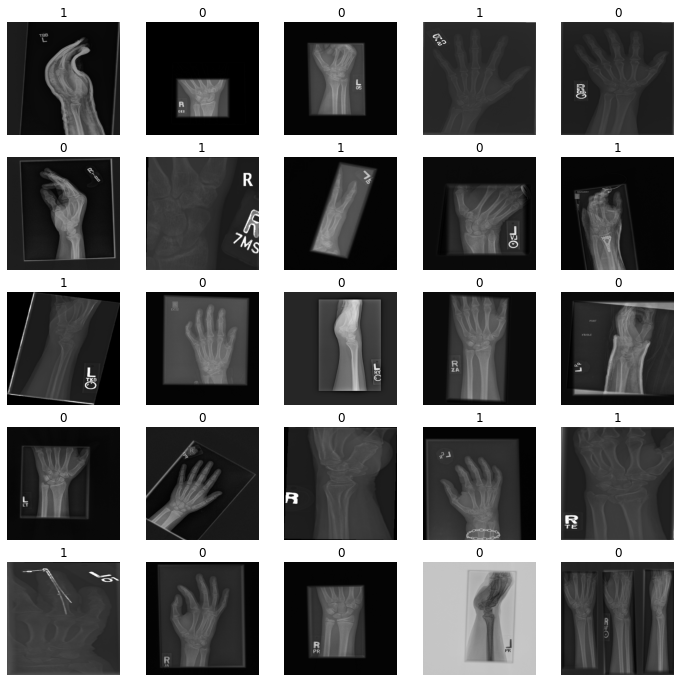

In [ ]:
train_images, train_labels = next(train_ds.as_numpy_iterator())
show_25_images(train_images, train_labels)

## Model configuration

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds.cache().prefetch(buffer_size = AUTOTUNE)
val_ds.cache().prefetch(buffer_size = AUTOTUNE)

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 480, 480, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [ ]:
import tensorflow_hub as hub

model_URL = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_l/classification/2"
num_classes = 1
INPUT_SHAPE = [None, 480, 480, 3]

model = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal",
                      input_shape = (480, 480, 3)),
    tf.keras.layers.RandomRotation(0.1),
    hub.KerasLayer(model_URL),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units = 1,
                          activation = "sigmoid")
])

In [ ]:
model.compile(optimizer = tf.keras.optimizers.Adam(0.001),
              loss = tf.keras.losses.BinaryCrossentropy(),
              metrics = ['accuracy'])
model.build(INPUT_SHAPE)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip (RandomFlip)    (None, 480, 480, 3)       0         
                                                                 
 random_rotation (RandomRota  (None, 480, 480, 3)      0         
 tion)                                                           
                                                                 
 keras_layer (KerasLayer)    (None, 1000)              119027848 
                                                                 
 dropout (Dropout)           (None, 1000)              0         
                                                                 
 dense (Dense)               (None, 1)                 1001      
                                                                 
Total params: 119,028,849
Trainable params: 1,001
Non-trainable params: 119,027,848
______________________________________

In [ ]:
%load_ext tensorboard

In [ ]:
import datetime

# Create function to build TensorBoard callback
def create_tensorboard_callback():
  logdir = os.path.join("drive/MyDrive/TFG/logs",
                        datetime.datetime.now().strftime("%Y%m%d-%H%M&S"))
  return tf.keras.callbacks.TensorBoard(logdir)

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                  patience = 6) # stops after 6 rounds of no improvements

In [ ]:
# Callbacks to save the epoch with best val_accuracy
checkpoint_filepath = "/content/drive/MyDrive/TFG/models/checkpoints"

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

## Training The Model

In [ ]:
tensorboard = create_tensorboard_callback()

epochs = 100
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs = epochs,  
    verbose = 1,
    callbacks = [tensorboard, early_stopping, model_checkpoint_callback]
)

Epoch 1/100
319/319 [==============================] - 818s 2s/step - loss: 0.5775 - accuracy: 0.7036 - val_loss: 0.6252 - val_accuracy: 0.6525
Epoch 2/100
319/319 [==============================] - 183s 574ms/step - loss: 0.5293 - accuracy: 0.7445 - val_loss: 0.6200 - val_accuracy: 0.6696
Epoch 3/100
319/319 [==============================] - 184s 576ms/step - loss: 0.5232 - accuracy: 0.7490 - val_loss: 0.5698 - val_accuracy: 0.7108
Epoch 4/100
319/319 [==============================] - 183s 574ms/step - loss: 0.5141 - accuracy: 0.7590 - val_loss: 0.5598 - val_accuracy: 0.7171
Epoch 5/100
319/319 [==============================] - 184s 576ms/step - loss: 0.5121 - accuracy: 0.7575 - val_loss: 0.5491 - val_accuracy: 0.7272
Epoch 6/100
319/319 [==============================] - 180s 564ms/step - loss: 0.5122 - accuracy: 0.7558 - val_loss: 0.5683 - val_accuracy: 0.7032
Epoch 7/100
319/319 [==============================] - 180s 565ms/step - loss: 0.5098 - accuracy: 0.7580 - val_loss: 0.55

In [3]:
model.load_weights(checkpoint_filepath)
model.save("/content/drive/MyDrive/TFG/models/mura_effnet_hand.h5")

NameError: ignored

## Visualizing training results

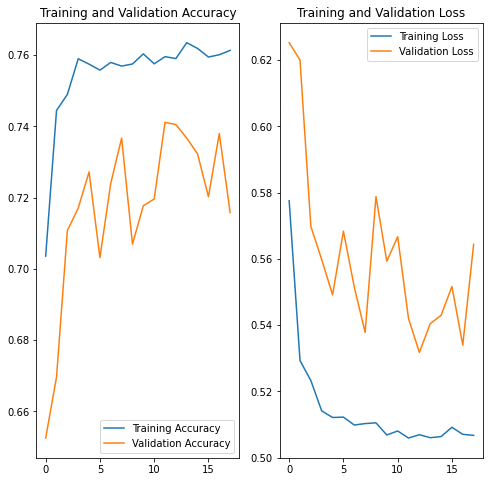

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
num_epochs = 18 # Manually insert
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Evaluating the baseline model

In [4]:
# Loading saved model
model = tf.keras.models.load_model("/content/drive/MyDrive/TFG/models/mura_effnet_hand.h5", custom_objects={'KerasLayer': hub.KerasLayer})

In [19]:
# Making predictions on the validation set

pred_prob = model.predict(val_ds)

25/25 [==============================] - 289s 11s/step


In [20]:
pred_prob

array([[0.62249345],
       [0.2673188 ],
       [0.5129009 ],
       ...,
       [0.1576628 ],
       [0.069184  ],
       [0.06800062]], dtype=float32)

In [21]:
predictions = []
for prob in pred_prob:
  if prob < 0.5:
    predictions.append(0)
  if prob >= 0.5:
    predictions.append(1)

In [22]:
print(classification_report(y_val, predictions, target_names = ["0", "1"]))

              precision    recall  f1-score   support

           0       0.70      0.91      0.79       849
           1       0.84      0.54      0.66       731

    accuracy                           0.74      1580
   macro avg       0.77      0.73      0.73      1580
weighted avg       0.77      0.74      0.73      1580



### ROC Curve

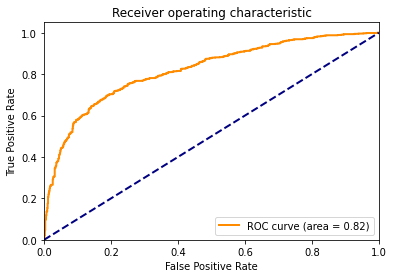

In [23]:
fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_val, pred_prob)
plt.figure()
lw = 2
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % sklearn.metrics.auc(fpr, tpr),
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.legend(loc="lower right")
plt.show()

In [24]:
# To find the point closest to the top left corner
roc_array = np.column_stack((fpr, tpr, thresholds))

# Distance from point to top left corner is: sqrt((1-fpr)^2 + (1-tpr)^2)
distances = np.sqrt(np.square(fpr) + np.square((1-tpr)))
opt_threshold_index = np.argmin(distances)
optimal_threshold = thresholds[opt_threshold_index] 
optimal_threshold

0.34664166

In [25]:
predictions = []
for prob in pred_prob:
  if prob < optimal_threshold:
    predictions.append(0)
  if prob >= optimal_threshold:
    predictions.append(1)

In [26]:
print(classification_report(y_val, predictions, target_names = ["0", "1"]))

              precision    recall  f1-score   support

           0       0.77      0.79      0.78       849
           1       0.75      0.72      0.73       731

    accuracy                           0.76      1580
   macro avg       0.76      0.75      0.75      1580
weighted avg       0.76      0.76      0.76      1580



### Confusion matrix

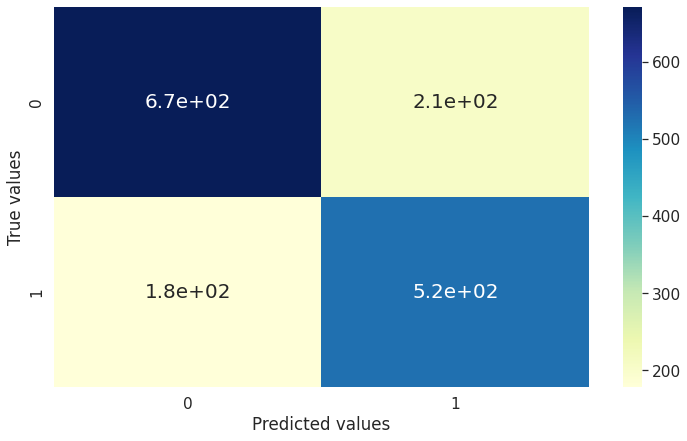

In [27]:
# Confusion matrix
cm = confusion_matrix(predictions, y_val)
plt.figure(figsize = (12, 7))
sns.set(font_scale = 1.4)
ax = sns.heatmap(cm, annot = True, annot_kws = {"size": 20}, cmap = "YlGnBu");
ax.set(xlabel = "Predicted values", ylabel = "True values")
plt.show;

## Unbatchifying validation dataset

In [28]:
# Unbatchify data
def unbatchify(data):
  images = []
  labels = []
  # Loop through unbatched data
  for image, label in data.unbatch().as_numpy_iterator():
    images.append(image)
    labels.append(label)
  return images, labels

# Unbatch val data
val_images, val_labels = unbatchify(val_ds)
sum(val_labels)

731

## Plotting predictions

In [29]:
def get_pred_label(prob, threshold = optimal_threshold):
  if prob > threshold:
    prediction = 1
  if prob <= threshold:
    prediction = 0
  return prediction

In [30]:
def plot_pred(prediction_probabilities, labels, images):
  n = random.randint(0, len(val_labels))
  pred_prob, true_label, image = prediction_probabilities[n], labels[n], images[n]

  # Get pred label
  pred_label = get_pred_label(pred_prob)

  # Plot image and remove ticks
  plt.imshow(image)
  plt.xticks([])
  plt.yticks([])

  # Change color of title depending on if the prediction is right or wrong
  if pred_label == true_label:
    color = "green"
  else:
    color = "red"
  plt.title("{} {:2.0f}% ({})".format(pred_label,
                                      np.max(pred_prob)*100,
                                      true_label),
                                      color=color)

In [31]:
random.randint(0, len(val_labels))

997

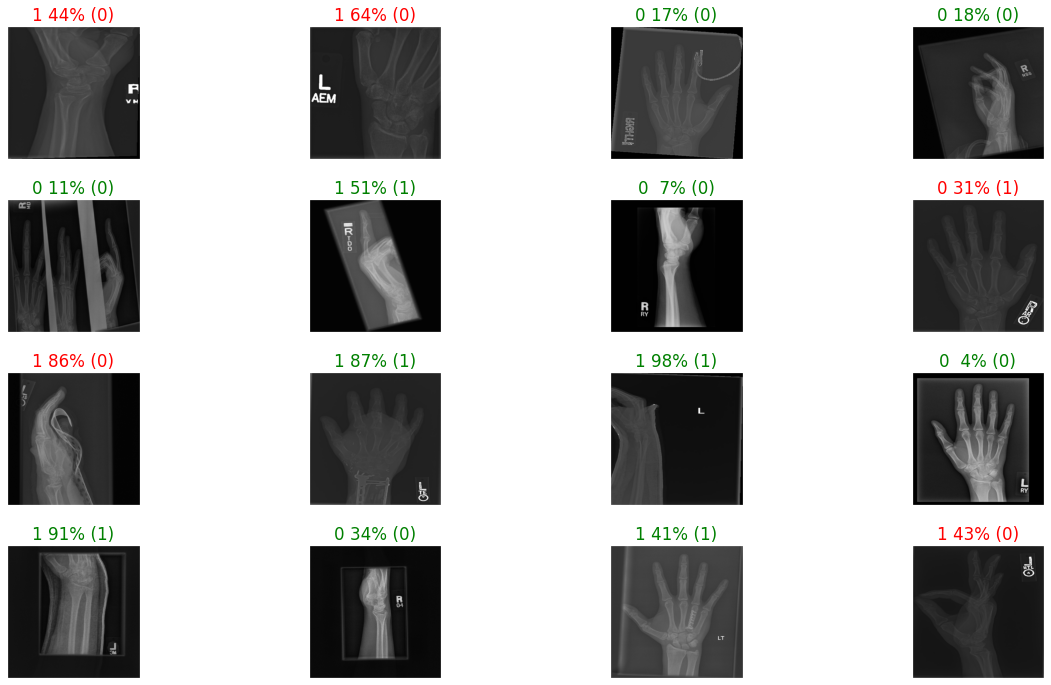

In [32]:
# Let's check a few random predictions and their different values
i_multiplier = 20
num_rows = 4
num_cols = 4
num_images = num_rows*num_cols
random_image_index = random.sample(range(0, len(val_labels)), num_images)
plt.figure(figsize=(17, 10))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_pred(prediction_probabilities=pred_prob,
            labels=val_labels,
            images=val_images)
plt.tight_layout(h_pad=1.0)
plt.show()

## Changing from Image Predictions to Study Predictions

In [33]:
predictions_df = pd.DataFrame(data = np.column_stack((X_val, val_labels, predictions, pred_prob)), columns = ["Path", "True Label", "Predicted Label", "Pred Score"])
predictions_df

,Path,True Label,Predicted Label,Pred Score
0,/content/drive/Othercomputers/macbookpro/MURA-v1.1/valid/XR_WRIST/patient11185/study1_positive/image1.png,1,1,0.622493
1,/content/drive/Othercomputers/macbookpro/MURA-v1.1/valid/XR_WRIST/patient11185/study1_positive/image2.png,1,0,0.267319
2,/content/drive/Othercomputers/macbookpro/MURA-v1.1/valid/XR_WRIST/patient11185/study1_positive/image3.png,1,1,0.512901
3,/content/drive/Othercomputers/macbookpro/MURA-v1.1/valid/XR_WRIST/patient11185/study1_positive/image4.png,1,1,0.497936
4,/content/drive/Othercomputers/macbookpro/MURA-v1.1/valid/XR_WRIST/patient11186/study1_positive/image1.png,1,1,0.792498
...,...,...,...,...
1575,/content/drive/Othercomputers/macbookpro/MURA-v1.1/valid/XR_FINGER/patient11967/study1_negative/image3.png,0,0,0.191133
1576,/content/drive/Othercomputers/macbookpro/MURA-v1.1/valid/XR_FINGER/patient11967/study1_negative/image4.png,0,0,0.141077
1577,/content/drive/Othercomputers/macbookpro/MURA-v1.1/valid/XR_FINGER/patient11738/study1_negative/image1.png,0,0,0.157663
1578,/content/drive/Othercomputers/macbookpro/MURA-v1.1/valid/XR_FINGER/patient11738/study1_negative/image2.png,0,0,0.069184


In [43]:
predictions_studies = [get_study(i) for i in predictions_df["Path"]]
predictions_df["Study"] = predictions_studies

In [44]:
predictions_df

,Path,True Label,Predicted Label,Pred Score,Study
0,/content/drive/Othercomputers/macbookpro/MURA-v1.1/valid/XR_WRIST/patient11185/study1_positive/image1.png,1,1,0.622493,patient11185/study1_positive
1,/content/drive/Othercomputers/macbookpro/MURA-v1.1/valid/XR_WRIST/patient11185/study1_positive/image2.png,1,0,0.267319,patient11185/study1_positive
2,/content/drive/Othercomputers/macbookpro/MURA-v1.1/valid/XR_WRIST/patient11185/study1_positive/image3.png,1,1,0.512901,patient11185/study1_positive
3,/content/drive/Othercomputers/macbookpro/MURA-v1.1/valid/XR_WRIST/patient11185/study1_positive/image4.png,1,1,0.497936,patient11185/study1_positive
4,/content/drive/Othercomputers/macbookpro/MURA-v1.1/valid/XR_WRIST/patient11186/study1_positive/image1.png,1,1,0.792498,patient11186/study1_positive
...,...,...,...,...,...
1575,/content/drive/Othercomputers/macbookpro/MURA-v1.1/valid/XR_FINGER/patient11967/study1_negative/image3.png,0,0,0.191133,patient11967/study1_negative
1576,/content/drive/Othercomputers/macbookpro/MURA-v1.1/valid/XR_FINGER/patient11967/study1_negative/image4.png,0,0,0.141077,patient11967/study1_negative
1577,/content/drive/Othercomputers/macbookpro/MURA-v1.1/valid/XR_FINGER/patient11738/study1_negative/image1.png,0,0,0.157663,patient11738/study1_negative
1578,/content/drive/Othercomputers/macbookpro/MURA-v1.1/valid/XR_FINGER/patient11738/study1_negative/image2.png,0,0,0.069184,patient11738/study1_negative


In [80]:
study_df = predictions_df.groupby(["Study"]).mean()
study_df

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: FutureWarning: Dropping invalid columns in DataFrameGroupBy.mean is deprecated. In a future version, a TypeError will be raised. Before calling .mean, select only columns which should be valid for the function.
  exec(code_obj, self.user_global_ns, self.user_ns)


,True Label,Predicted Label,Pred Score
Study,,,
patient11185/study1_positive,1.0,0.75,0.475162
patient11186/study1_positive,1.0,1.00,0.811262
patient11186/study2_positive,1.0,1.00,0.653849
patient11186/study3_positive,1.0,1.00,0.818853
patient11187/study1_positive,1.0,0.00,0.320630
...,...,...,...
patient11963/study1_negative,0.0,1.00,0.481473
patient11964/study1_negative,0.0,0.00,0.330641
patient11965/study1_negative,0.0,0.00,0.074338


In [81]:
threshold = 0.4
new_predictions = []
for prob in study_df["Pred Score"]:
  if prob < threshold:
    new_predictions.append(0)
  if prob >= threshold:
    new_predictions.append(1)
study_df["Study Prediction"] = new_predictions

In [82]:
study_df

,True Label,Predicted Label,Pred Score,Study Prediction
Study,,,,
patient11185/study1_positive,1.0,0.75,0.475162,1
patient11186/study1_positive,1.0,1.00,0.811262,1
patient11186/study2_positive,1.0,1.00,0.653849,1
patient11186/study3_positive,1.0,1.00,0.818853,1
patient11187/study1_positive,1.0,0.00,0.320630,0
...,...,...,...,...
patient11963/study1_negative,0.0,1.00,0.481473,1
patient11964/study1_negative,0.0,0.00,0.330641,0
patient11965/study1_negative,0.0,0.00,0.074338,0


In [83]:
print(classification_report(study_df["True Label"], study_df["Study Prediction"], target_names = ["0", "1"]))

              precision    recall  f1-score   support

           0       0.78      0.90      0.83       304
           1       0.83      0.66      0.73       230

    accuracy                           0.79       534
   macro avg       0.80      0.78      0.78       534
weighted avg       0.80      0.79      0.79       534



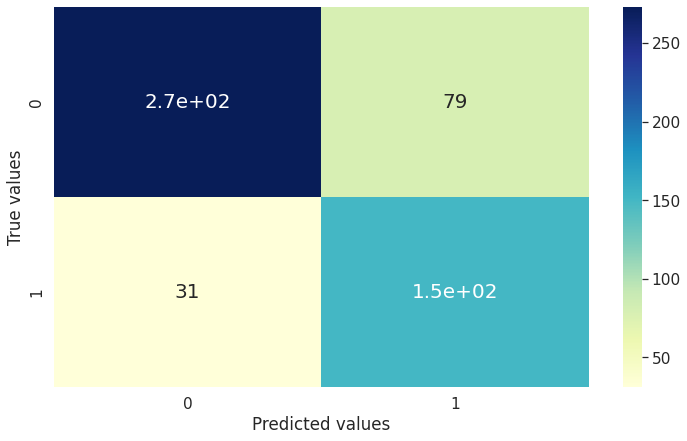

In [84]:
# Confusion matrix
cm = confusion_matrix(study_df["Study Prediction"], study_df["True Label"])
plt.figure(figsize = (12, 7))
sns.set(font_scale = 1.4)
ax = sns.heatmap(cm, annot = True, annot_kws = {"size": 20}, cmap = "YlGnBu");
ax.set(xlabel = "Predicted values", ylabel = "True values")
plt.show;

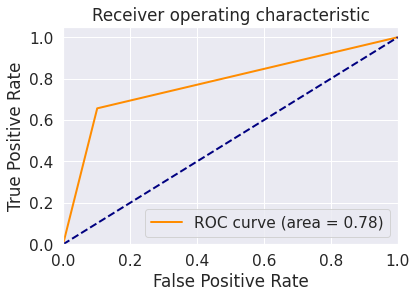

In [85]:
fpr, tpr, thresholds = sklearn.metrics.roc_curve(study_df["True Label"], study_df["Study Prediction"])
plt.figure()
lw = 2
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % sklearn.metrics.auc(fpr, tpr),
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.legend(loc="lower right")
plt.show()